In [1]:
# Load all helper functions
%run -i '../util/helper.py'

## Load and Split Data

In [54]:
# load dataset
df  = pd.read_csv('../Dataset/brazilian_ecommerce_scaled.csv')

#split dataset in features and target variable
y = df["is_delayed"]
X = df.drop(["is_delayed"], axis=1, inplace=False)

In [55]:
# split X and y into training and testing sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2, stratify=y)

In [56]:
print(X_dev.shape)
print(X_test.shape)

(92506, 29)
(23127, 29)


### Since the data is highly imbalanced (as seen below), I'll be using grid search to determine the optimal value of weights to be assigned to each class. Merely using class_weight='balanced' in the LogisticRegression Classifier is not able to make the model converge.

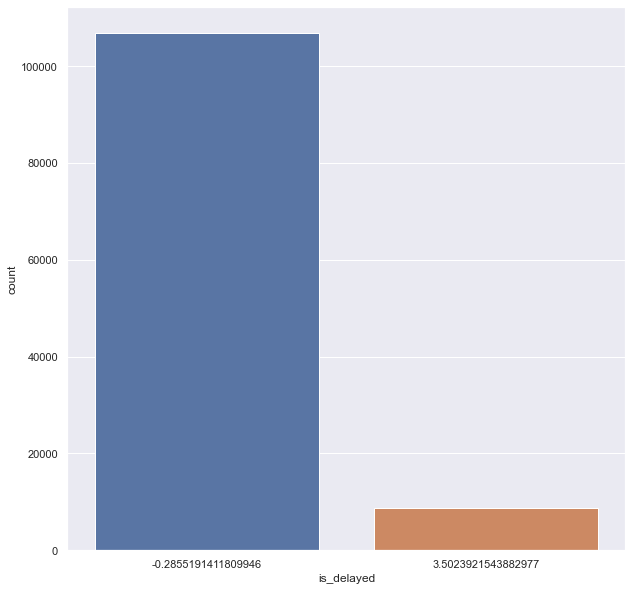

In [57]:
plt.rcParams["figure.figsize"] = (10, 10)
sns.set_theme(style="darkgrid")
g = sns.countplot(x = df['is_delayed'])

In [16]:
# num_features = ['quantity', 'price', 'freight_value', 'payment_sequential', 'payment_installments', 
#                 'payment_value', 'review_score', 'product_name_lenght', 'product_description_lenght',
#                 'product_photos_qty', 'product_weight_g', 'sale', 'distance', 'year', 'month', 'day', 
#                 'is_holiday', 'product_volume_cm', 'x0_boleto', 'x0_credit_card', 'x0_debit_card', 
#                 'x0_voucher', 'order_status', 'product_category_name', 'customer_city', 'customer_state',
#                 'seller_city', 'seller_state', 'daypart']

In [24]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
# dev_X_scaled = scaler.fit_transform(X_dev[num_features])
# dev_X_scaled = pd.DataFrame(dev_X_scaled, columns=num_features)
# test_X_scaled = scaler.transform(X_test[num_features])
# test_X_scaled = pd.DataFrame(test_X_scaled, columns=num_features)

# Hyperparameter Tuning

## Stratified Sampling

### GridSearch

In [60]:
penalty = ['l2', 'none', 'elasticnet']
C = np.logspace(-1, 1, 5)
solver = ['newton-cg', 'sag']
# num_weights = np.linspace(0.0,0.99,50)
# weights = [{0:x, 1:1.0-x} for x in num_weights]
start3 = time()

parameter_grid = {'classifier__penalty': penalty,
                  'classifier__C': C,
                  'classifier__solver':solver}

pipe_logistic_tune = Pipeline([('classifier', LogisticRegression(random_state=random_state, class_weight='balanced'))])

pipe_logistic = make_pipeline(GridSearchCV(pipe_logistic_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10, shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1',
                                      verbose = 5))
pipe_logistic.fit(X_dev, np.ravel(y_dev))
end3 = time()
print("Logistic Regression model takes " + str(end3-start3) + "seconds")
print("The performance of the Logistic Regression model on test data is ", pipe_logistic.score(X_test, y_test))
grid_search_logistic = pipe_logistic.named_steps["gridsearchcv"]
print("The Logistic Regression model Best hyperparameters are {}".format(grid_search_logistic.best_params_))


Fitting 10 folds for each of 30 candidates, totalling 300 fits


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

## Evaluate on the Test Set

In [12]:
weights = np.linspace(0.0,0.99,50)
[{0:x, 1:1.0-x} for x in weights]

[{0: 0.0, 1: 1.0},
 {0: 0.02020408163265306, 1: 0.9797959183673469},
 {0: 0.04040816326530612, 1: 0.9595918367346938},
 {0: 0.06061224489795918, 1: 0.9393877551020409},
 {0: 0.08081632653061224, 1: 0.9191836734693878},
 {0: 0.1010204081632653, 1: 0.8989795918367347},
 {0: 0.12122448979591836, 1: 0.8787755102040816},
 {0: 0.14142857142857143, 1: 0.8585714285714285},
 {0: 0.16163265306122448, 1: 0.8383673469387756},
 {0: 0.18183673469387754, 1: 0.8181632653061225},
 {0: 0.2020408163265306, 1: 0.7979591836734694},
 {0: 0.22224489795918367, 1: 0.7777551020408163},
 {0: 0.24244897959183673, 1: 0.7575510204081632},
 {0: 0.2626530612244898, 1: 0.7373469387755103},
 {0: 0.28285714285714286, 1: 0.7171428571428571},
 {0: 0.3030612244897959, 1: 0.6969387755102041},
 {0: 0.32326530612244897, 1: 0.676734693877551},
 {0: 0.34346938775510205, 1: 0.656530612244898},
 {0: 0.3636734693877551, 1: 0.636326530612245},
 {0: 0.38387755102040816, 1: 0.6161224489795918},
 {0: 0.4040816326530612, 1: 0.595918367

In [ ]:
logistic_prediction = pipe_logistic.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, logistic_prediction)))
print('Recall: {}'.format(recall_score(y_test, logistic_prediction)))
print('Precision: {}'.format(precision_score(y_test, logistic_prediction)))
print('F-1 Score: {}'.format(f1_score(y_test, logistic_prediction)))

recall, precision = recall_score(y_test, logistic_prediction), precision_score(y_test, logistic_prediction)

In [ ]:
probs = pipe_logistic.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

NameError: name 'pipe_logistic' is not defined

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

NameError: name 'probs' is not defined

In [ ]:
filename = '../model/logistic_stratified.sav'
pickle.dump(pipe_logistic, open(filename, 'wb'))

## Downsampling

In [ ]:
rus = RandomUnderSampler(replacement=False, random_state=random_state)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

## GridSearch

In [ ]:
penalty = ['l2', 'none']
C = [np.logspace(-4, 4, 20)]
solver = ['newton-cg', 'lbfgs', 'sag', 'saga']
start3 = time()

parameter_grid = {'classifier__penalty' :penalty,
                  'classifier__C': C,
                  'classifier__solver':solver}

pipe_logistic_tune = Pipeline([('classifier', LogisticRegression(random_state=random_state))])

pipe_logistic_rus = make_pipeline(GridSearchCV(pipe_logistic_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_logistic_rus.fit(X_dev_us, np.ravel(y_dev_us))
end3 = time()
print("Logistic Regression model takes " + str(end3-start3) + "seconds")
print("The performance of the Logistic Regression model on test data is ", pipe_logistic_rus.score(X_test, y_test))
grid_search_logistic = pipe_logistic_rus.named_steps["gridsearchcv"]
print("The Logistic Regression model Best hyperparameters are {}".format(grid_search_logistic.best_params_))


## Evaluate on the Test Set

In [ ]:
logistic_prediction = pipe_logistic_rus.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(y_test, logistic_prediction)))
print('Recall: {}'.format(recall_score(y_test, logistic_prediction)))
print('Precision: {}'.format(precision_score(y_test, logistic_prediction)))
print('F-1 Score: {}'.format(f1_score(y_test, logistic_prediction)))

recall, precision = recall_score(y_test, logistic_prediction), precision_score(y_test, logistic_prediction)

NameError: name 'pipe_logistic' is not defined

In [ ]:
probs = pipe_logistic.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

In [ ]:
filename = '../Model/logistic_downsampling.sav'
pickle.dump(pipe_logistic_rus, open(filename, 'wb'))